<a href="https://colab.research.google.com/github/shivanshus/Emotion-DeepDream-Machine/blob/master/EDM_TF_and_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Asset 3

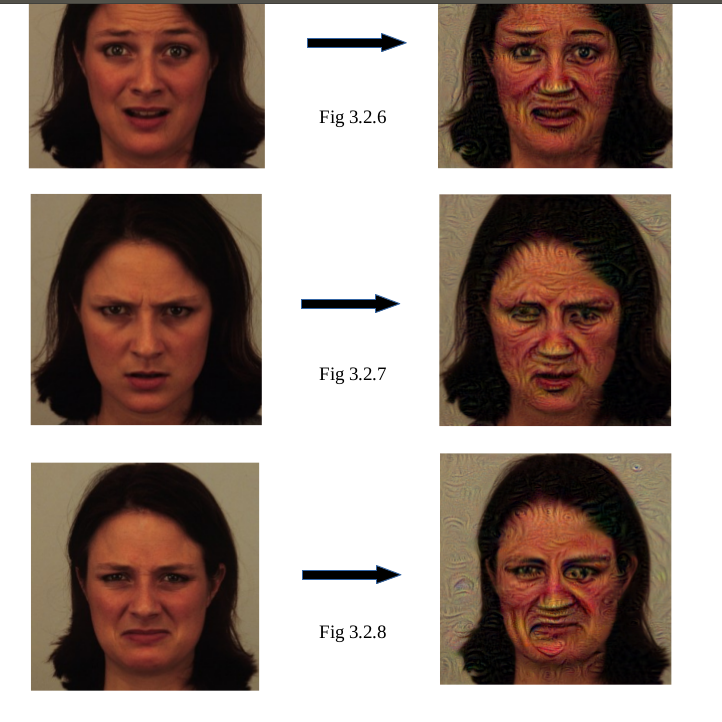

#import lib

In [ ]:
import time
import os
import errno
import subprocess
import math
import cv2

import numpy as np
import scipy.ndimage as nd
import PIL.Image
from google.protobuf import text_format

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import load_img, save_img,img_to_array
import matplotlib.image as mpimg
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

import scipy
import argparse

#preprocess

In [ ]:
def preprocess_image(img_path):
  img = load_img(img_path)
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  return img


#deprocess

In [ ]:

def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x


#make step (gradient ascent)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model
import io
model = load_model('/content/drive/My Drive/mobilenet_v2_kdef_130_fer_110.h5')


In [ ]:
layer_no = 0
for i, layer in enumerate(model.layers):
   layer_no += 1
   print(i, layer.name)
print('\n')
print('total number of layer in the model = {}'.format(layer_no))

0 input_1
1 Conv1_pad
2 Conv1
3 bn_Conv1
4 Conv1_relu
5 expanded_conv_depthwise
6 expanded_conv_depthwise_BN
7 expanded_conv_depthwise_relu
8 expanded_conv_project
9 expanded_conv_project_BN
10 block_1_expand
11 block_1_expand_BN
12 block_1_expand_relu
13 block_1_pad
14 block_1_depthwise
15 block_1_depthwise_BN
16 block_1_depthwise_relu
17 block_1_project
18 block_1_project_BN
19 block_2_expand
20 block_2_expand_BN
21 block_2_expand_relu
22 block_2_depthwise
23 block_2_depthwise_BN
24 block_2_depthwise_relu
25 block_2_project
26 block_2_project_BN
27 block_2_add
28 block_3_expand
29 block_3_expand_BN
30 block_3_expand_relu
31 block_3_pad
32 block_3_depthwise
33 block_3_depthwise_BN
34 block_3_depthwise_relu
35 block_3_project
36 block_3_project_BN
37 block_4_expand
38 block_4_expand_BN
39 block_4_expand_relu
40 block_4_depthwise
41 block_4_depthwise_BN
42 block_4_depthwise_relu
43 block_4_project
44 block_4_project_BN
45 block_4_add
46 block_5_expand
47 block_5_expand_BN
48 block_5_exp

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

model_dog = InceptionV3(weights='imagenet', include_top=False)
print('model loaded')

87916544/87910968 [==============================] - 1s 0us/step
model loaded


In [ ]:
import io
import numpy as np
import tensorflow as tf

url = '/content/test_img.JPG'

def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'neutral','sad' , 'surprised')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

from tensorflow.keras.preprocessing import image
img = image.load_img(url)
#img=tf.image.rgb_to_grayscale(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
 
x /= 255
 
custom = model.predict(x)
emotion_analysis(custom[0])
 
plt.show()

In [ ]:
tf.compat.v1.disable_eager_execution()

settings = {
    'features': {
        

        'block_15_add':1.0,
                
             
    },
}


dream = model.input
print('Model loaded.')

# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    if layer_name not in layer_dict:
        raise ValueError('Layer ' + layer_name + ' not found in model.')
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss = loss + coeff * K.sum(K.square(x)) / scaling
    else:
        loss = loss + coeff * K.sum(K.square(x)) / scaling

# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

Model loaded.


# resize

In [ ]:

def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)

#Deep Dream

In [ ]:
def deepdream(model, img_path, iterations, num_octave, step, octave_scale, max_loss):
    img = preprocess_image(img_path)
    if K.image_data_format() == 'channels_first':
       original_shape = img.shape[2:]
    else:
      original_shape = img.shape[1:3]
    successive_shapes = [original_shape]
    for i in range(1, num_octave):
        shape = tuple([int(dim / (octave_scale ** (i))) for dim in original_shape])
        successive_shapes.append(shape)
    successive_shapes = successive_shapes[::-1]
    original_img = np.copy(img)
    shrunk_original_img = resize_img(img, successive_shapes[0])

    for shape in successive_shapes:
         print('Processing image shape', shape)
         img = resize_img(img, shape)
         img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
         upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
         same_size_original = resize_img(original_img, shape)
         lost_detail = same_size_original - upscaled_shrunk_original_img

         img += lost_detail
         shrunk_original_img = resize_img(original_img, shape)
    dream_img = deprocess_image(np.copy(img))
    save_img('dream.png', dream_img)

    return dream_img

#Emotion DD VOF

In [ ]:
# for emotions
#mixed3:1.5
iterations = 30
num_octave = 5
step = 0.01
octave_scale = 1.8
max_loss =20 
#img_path = '/content/rob.jpg'
#range = 1-5

In [ ]:
for i in range(1,5):
    deepdream(model, img_path, iterations, num_octave, step, octave_scale, max_loss)
    img_path = '/content/dream.png'

In [ ]:
vidinput = cv2.VideoCapture('/content/test_vid.mp4')
vids = []
var_counter = 0
while(vidinput.isOpened()):
  ret, frame = vidinput.read()
  if ret == False:
    break
  cv2.imwrite("frame%d.jpg" % var_counter, frame)
  vids.append(frame)
  var_counter += 1
print(var_counter)
print(len(vids))

125
125


In [ ]:
#emotions
for i in range(len(vids)):
  img_path = '/content/'+'frame{}.jpg'.format(i)
  img = preprocess_image(img_path)
  #for i in range(1,5):
  dream=deepdream(model, img_path, iterations, num_octave, step, octave_scale, max_loss)
  img_path = '/content/dream.png'
  dream=deepdream(model, img_path, iterations, num_octave, step, octave_scale, max_loss)
  img_path = '/content/dream.png'
  dream=deepdream(model, img_path, iterations, num_octave, step, octave_scale, max_loss)
  img_path = '/content/dream.png'
  dream=deepdream(model, img_path, iterations, num_octave, step, octave_scale, max_loss)
  img_path = '/content/dream.png'
  
  print('frame:',i)
  np.clip(dream, 0, 255).astype('uint8')
  save_img('dream_frame{}.jpg'.format(i), dream)

Streaming output truncated to the last 5000 lines.
..Loss value at 1 : 17.972239
..Loss value at 2 : 19.696178
Processing image shape (123, 219)
..Loss value at 0 : 15.420246
..Loss value at 1 : 19.332827
Processing image shape (222, 395)
..Loss value at 0 : 13.408694
..Loss value at 1 : 16.69716
..Loss value at 2 : 18.908335
Processing image shape (400, 711)
..Loss value at 0 : 13.698395
..Loss value at 1 : 16.985603
..Loss value at 2 : 18.92414
Processing image shape (720, 1280)
..Loss value at 0 : 14.277486
..Loss value at 1 : 17.207188
..Loss value at 2 : 18.965807
Processing image shape (68, 121)
..Loss value at 0 : 15.41521
..Loss value at 1 : 18.857351
Processing image shape (123, 219)
..Loss value at 0 : 16.222013
Processing image shape (222, 395)
..Loss value at 0 : 15.057992
..Loss value at 1 : 18.168936
Processing image shape (400, 711)
..Loss value at 0 : 15.1959915
..Loss value at 1 : 18.012362
..Loss value at 2 : 19.74651
Processing image shape (720, 1280)
..Loss value at

In [ ]:
import cv2
import numpy as np
import glob
 
img_array = []
for i in range(192):
    for filename in glob.glob('/content/dream_frame{}.jpg'.format(i)):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
 
 
out = cv2.VideoWriter('dream_emotion_19may.avi',cv2.VideoWriter_fourcc(*'DIVX'), 24, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
settings = {
    'features': {
            
        'mixed4':0.5,     
                            
    },
}


dream = model_dog.input
print('Model loaded.')

# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model_dog.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    if layer_name not in layer_dict:
        raise ValueError('Layer ' + layer_name + ' not found in model.')
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss = loss + coeff * K.sum(K.square(x)) / scaling
    else:
        loss = loss + coeff * K.sum(K.square(x)) / scaling

# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

Model loaded.


In [ ]:
def deepdream(model, img_path, iterations, num_octave, step, octave_scale, max_loss):
    img = preprocess_image(img_path)
    if K.image_data_format() == 'channels_first':
       original_shape = img.shape[2:]
    else:
      original_shape = img.shape[1:3]
    successive_shapes = [original_shape]
    for i in range(1, num_octave):
        shape = tuple([int(dim / (octave_scale ** (i))) for dim in original_shape])
        successive_shapes.append(shape)
    successive_shapes = successive_shapes[::-1]
    original_img = np.copy(img)
    shrunk_original_img = resize_img(img, successive_shapes[0])

    for shape in successive_shapes:
         print('Processing image shape', shape)
         img = resize_img(img, shape)
         img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
         upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
         same_size_original = resize_img(original_img, shape)
         lost_detail = same_size_original - upscaled_shrunk_original_img

         img += lost_detail
         shrunk_original_img = resize_img(original_img, shape)
    dream_img = deprocess_image(np.copy(img))
    save_img('dream.png', dream_img)

    return dream_img

#Dog DD VOF

In [ ]:
# for dogs
#mixed4:0.5
iterations = 20
num_octave = 5
step = 0.01
octave_scale = 1.8
max_loss = 15
#img_path = '/content/rob.jpg'
#range = 1-4

In [ ]:
vidinput = cv2.VideoCapture('/content/testing.mp4')
vids = []
var_counter = 0
while(vidinput.isOpened()):
  ret, frame = vidinput.read()
  if ret == False:
    break
  cv2.imwrite("frame%d.jpg" % var_counter, frame)
  vids.append(frame)
  var_counter += 1
print(var_counter)
print(len(vids))

84
84


In [ ]:
#emotions
for i in range(len(vids)):
  img_path = '/content/'+'frame{}.jpg'.format(i)
  img = preprocess_image(img_path)
  #for i in range(1,5):
  dream=deepdream(model, img_path, iterations, num_octave, step, octave_scale, max_loss)
  img_path = '/content/dream.png'
  dream=deepdream(model, img_path, iterations, num_octave, step, octave_scale, max_loss)
  img_path = '/content/dream.png'
  dream=deepdream(model, img_path, iterations, num_octave, step, octave_scale, max_loss)
  img_path = '/content/dream.png'
  
  
  print('frame:',i)
  np.clip(dream, 0, 255).astype('uint8')
  save_img('dream_frame{}.jpg'.format(i), dream)

Processing image shape (102, 182)
..Loss value at 0 : 0.18623765
..Loss value at 1 : 0.2545819
..Loss value at 2 : 0.32213473
..Loss value at 3 : 0.3832974
..Loss value at 4 : 0.43673155
..Loss value at 5 : 0.48647836
..Loss value at 6 : 0.53543824
..Loss value at 7 : 0.5931677
..Loss value at 8 : 0.6315285
..Loss value at 9 : 0.6775089
..Loss value at 10 : 0.7233235
..Loss value at 11 : 0.76908
..Loss value at 12 : 0.8100707
..Loss value at 13 : 0.852658
..Loss value at 14 : 0.8932851
..Loss value at 15 : 0.93149877
..Loss value at 16 : 0.9668952
..Loss value at 17 : 1.0062594
..Loss value at 18 : 1.0506494
..Loss value at 19 : 1.0882013
Processing image shape (185, 329)
..Loss value at 0 : 0.13993141
..Loss value at 1 : 0.20660116
..Loss value at 2 : 0.27173713
..Loss value at 3 : 0.33217633
..Loss value at 4 : 0.38427407
..Loss value at 5 : 0.44324872
..Loss value at 6 : 0.5023143
..Loss value at 7 : 0.55772096
..Loss value at 8 : 0.61256415
..Loss value at 9 : 0.66487557
..Loss val

KeyboardInterrupt: ignored

In [ ]:
import cv2
import numpy as np
import glob
 
img_array = []
for i in range(14):
    for filename in glob.glob('/content/dream_frame{}.jpg'.format(i)):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
 
 
out = cv2.VideoWriter('dream_dog.avi',cv2.VideoWriter_fourcc(*'DIVX'), 7, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
flow = 1
blendflow = 0.
blendstatic = 0.1

In [ ]:

if flow is 1:
  var_counter = 0
  img_path = '/content' + '/' + 'frame{}.jpg'.format(var_counter)
  print(img_path)
  img = preprocess_image(img_path)
  h,w,c = img.shape[1], img.shape[2], img.shape[3]
  print(h,w,c)
  hallu = deepdream(model, img_path, iterations, num_octave, step, octave_scale, max_loss)
  print(hallu, type(hallu))
  np.clip(hallu, 0, 255, out=hallu).astype('uint8')
  save_img('dream_frame{}.jpg'.format(var_counter), hallu)
  grayImg = cv2.cvtColor(hallu, cv2.COLOR_RGB2GRAY)
  for v in range(len(vids)):
    if var_counter < len(vids):
      previousImg = img
      previousGrayImg = grayImg
      newframe = '/content' + '/' + 'frame{}.jpg'.format(v+1)
      print('Processing :'+ newframe)
      
      #calculating optical flow
      newframe = preprocess_image(newframe)
      print(newframe.shape)
      grayImg = cv2.cvtColor(newframe, cv2.COLOR_RGB2GRAY)
      flow = cv2.calcOpticalFlowFarneback(previousGrayImg, grayImg,flow =0.5, pyr_scale=0.5, levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
      inv_flow = flow
      flow = -flow
      flow[:,:,0]+=np.arange(w)
      flow[:,:,1]+=np.arange(h)[:,np.newaxis]

      #area of optical flow is shifted and merged into current frame
      if blendflow == 0:
        halludiff = previousImg - previousImg
      else:
        preframe =  '/content' + '/' + 'frame{}.jpg'.format(v)
        preframe =  preprocess_image(preframe)
        saveframe = 'dream_frame{}.jpg'.format(v)
        save_frame = preprocess_image(saveframe)
        halludiff = morphPicture(preframe,saveframe, blendflow) - previousImg
      
      halludiff = cv2.remap(halludiff, flow, None, cv2.INTER_LINEAR) 
      print(type(halludiff))
      hallu_flow = img + halludiff

      
      now = time.time()
      hallu = deepdream(model, img_path, iterations, num_octave, step, octave_scale, max_loss)
      later = time.time()
      print('time taken :',later-now)
      np.clip(hallu, 0, 255).astype('uint8')
      save_img('dream_frame{}.jpg'.format(var_counter))
      var_counter += 1

    else:
      print('finished processing all the frames')

    

/content/frame0.jpg
360 480 3
Processing image shape (61, 82)
..Loss value at 0 : 6.0454884
Processing image shape (95, 127)
..Loss value at 0 : 5.350803
Processing image shape (149, 198)
..Loss value at 0 : 4.635589
..Loss value at 1 : 13.706134
Processing image shape (231, 308)
..Loss value at 0 : 6.45517
Processing image shape (360, 480)
..Loss value at 0 : 4.864021
..Loss value at 1 : 12.293488
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]] <class 'numpy.ndarray'>
Processing :/content/frame1.jpg
(1, 360, 480, 3)


error: ignored

In [ ]:
#create a mask from the optical flow
      magnitude, angle = cv2.cartToPolar(inv_flow[0], inv_flow[1])
      print(magnitude, angle)
      norm_mag = cv2.normalize(magnitude,None,0,255,cv2.NORM_MINMAX)
      ret, mask = cv2.threshold(norm_mag, flowthresh, 255, cv2.THRESH_BINARY)
      flow_mask = mask.astype(np.uint8).reshape((h,w,1))

      #applying mask to optical flow
      hallu_flow_masked = cv2.bitwise_and(hallu_flow, hallu_flow, mask=flow_mask)

      #blending the area with no optical flow
      background_blendimg = cv2.addWeighted( img, (1-blendstatic), hallu, blendstatic, 0)
      background_masked =  cv2.bitwise_and(background_blendimg, background_blendimg, 
                                           mask=cv2.bitwise_not(flow_mask))
      #combine the optical flow and the background
      hallu = hallu_flow_masked + background_masked